# Plot Raster Map

### Import required packages.

In [1]:
# General imports:
import snowflake.connector
import pandas as pd
import geopandas as gpd
import os
from dotenv import load_dotenv

# Cartopy plotting imports:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

# Load environment variables.
load_dotenv()


True

### Connect to snowflake and pull variables of interest.

**SQL Query Breakdown:**

We begin by selecting the data variables we are interested in, as well as the year, x (longitude), y (latitude), CRS and pixel boundary columns, which will be used in plotting. 
```SQL
    SELECT
        year,
        x,
        y,
        aboveground_live_carbon_density,
        crs,
        st_aswkt(boundary) as boundary,
```

Next, we use the SQL clause 'FROM' to indicate which dataset the variables should be pulled from.
```SQL
    FROM
        planet.raw_forest_carbon_diligence_30_m
```

Finally, we use the clause 'WHERE' to select only one year of data for plotting.
```SQL
    WHERE
        year = 2020
```

In [2]:
# Define the SQL query to get ACD data from Planet for 2020.
sql_query = """
    SELECT
        year,
        x,
        y,
        aboveground_live_carbon_density,
        crs,
        st_aswkt(boundary) as boundary,
    FROM
        planet.raw_forest_carbon_diligence_30_m
    WHERE
        year = 2020
    """

# Connect to database and execute query.
with snowflake.connector.connect(
        account = os.getenv('DB_ACCOUNT'),
        warehouse = os.getenv('DB_WAREHOUSE'),
        database = os.getenv('DB_DATABASE'), 
        user = os.getenv('DB_USERNAME'),
        password = os.getenv('DB_PASSWORD')
) as conn:
    cur = conn.cursor().execute(sql_query)
    df = cur.fetch_pandas_all()


## Option 1: Plot from Pandas Dataframe.

<Axes: xlabel='X', ylabel='Y'>

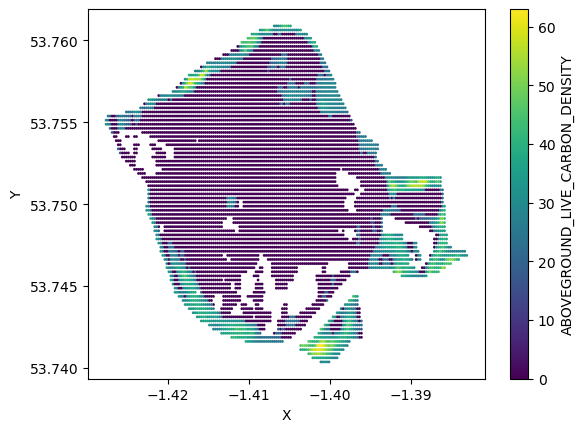

In [3]:
# Plot the data directly from pandas dataframe.
df.plot(x="X", y="Y", # Plot latitude on y axis and longitude on x axis.
               kind="scatter", # Set the type of plot to be a scatter plot.
               s=1, # Set the marker size (higher numbers indicate larger markers)
               c="ABOVEGROUND_LIVE_CARBON_DENSITY", # Set the variable to color the markers by. 
               colormap="viridis", # Set the colormap.
               ) 

## Option 2: Plot from XArray. 

In [4]:
# Set the columns to numeric type.
df[['Y', 'X', 'ABOVEGROUND_LIVE_CARBON_DENSITY']] = df[['Y', 'X', 'ABOVEGROUND_LIVE_CARBON_DENSITY']].apply(pd.to_numeric)

# Set dataframe indices before converting to xarray. 
data_df = df.set_index(['YEAR','Y', 'X'])
data_xarr = data_df.to_xarray()

### Plot directly from xarray:

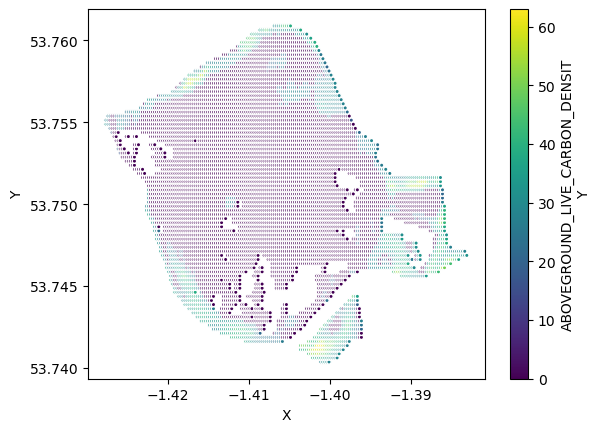

In [5]:
data_xarr.plot.scatter(x="X", y="Y", # Plot latitude on y axis and longitude on x axis.
                         hue="ABOVEGROUND_LIVE_CARBON_DENSITY", # Set the variable to color the markers by. 
                         add_colorbar=True, # Add a colorbar to the plot.
                         s=10, # Set the markersize.
                         cmap="viridis") # Set the colormap.

### Plot from matplotlib:

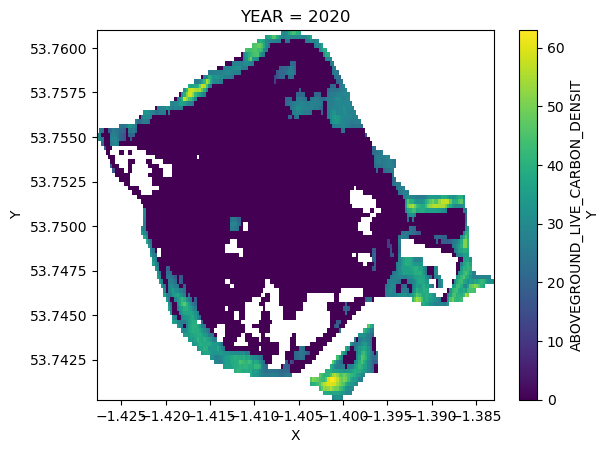

In [6]:
data_xarr['ABOVEGROUND_LIVE_CARBON_DENSITY'].plot(cmap='viridis')

## Option 3: Plot with Geopandas

<Axes: >

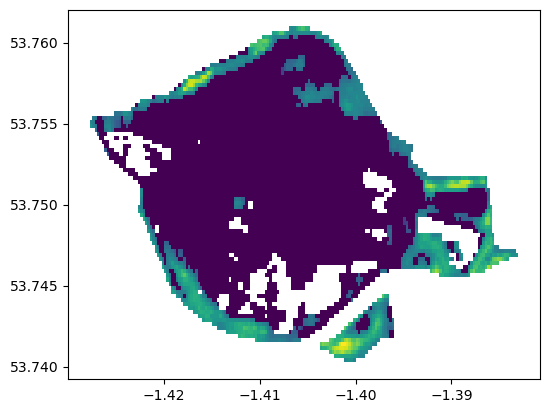

In [7]:
# Convert pandas dataframe to geodataframe and then plot using pixel boundary.
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df["BOUNDARY"]), crs=df.iloc[0]["CRS"])
gdf.plot("ABOVEGROUND_LIVE_CARBON_DENSITY")

## Option 4: Plot with basemap from Cartopy.

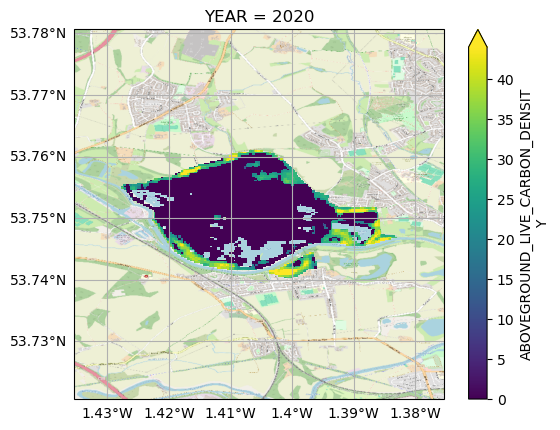

In [8]:
# Select OSM basemap imagery.
imagery = OSM()

# Set up matplotlib figure.
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Calculate the center of the AOI.
lon = data_xarr.coords['X']
lat = data_xarr.coords['Y']
lon_center = float(lon.mean())
lat_center = float(lat.mean())

# Set zoom factor (higher values zoom out more).
zoom_out_factor = 0.03 

# Set map frame extent based on AOI and zoom factor.
extent = [lon_center - zoom_out_factor, lon_center + zoom_out_factor,
          lat_center - zoom_out_factor, lat_center + zoom_out_factor]
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add the basemap imagery to the map.
ax.add_image(imagery, 15)

# Plot the data onto the basemap.
data_xarr['ABOVEGROUND_LIVE_CARBON_DENSITY'].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    robust=True
)

# Add gridlines and set labels on the left and bottom only.
gl = ax.gridlines(draw_labels=True)
gl.left_labels = True
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = True

# Show the plot
plt.show()
